In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk
from transformers import set_seed

SEED = 42
set_seed(SEED)
all_stream_data = load_from_disk("data/processed/all_stream_data")


In [2]:
from transformers import AutoTokenizer
import torch

model_id = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [3]:
train_dataset = all_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = all_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


In [4]:
labels = all_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [5]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# from huggingface_hub import notebook_login
# notebook_login()


In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 32
num_train_epochs = 4
learning_rate = 2e-5
model_name = f"./models/{model_id}-finetuned-arxiv-{SEED}"

training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  weight_decay=0.01,
                                  warmup_steps=500,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size * 2,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  disable_tqdm=False,
                                  logging_strategy="steps",
                                  logging_steps=500,
                                  logging_dir=f"{model_name}/logs",
                                  log_level="error",
                                  report_to="tensorboard",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=False,
                                  label_smoothing_factor=0.1,
                                  save_steps=500,
                                  save_strategy="steps",
                                  save_total_limit=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [9]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
500,1.679800,1.111568,0.383499,0.387031
1000,1.077700,1.020386,0.514574,0.510778
1500,1.009800,0.972326,0.581825,0.578476
2000,0.976100,0.969702,0.599507,0.583756
2500,0.928100,0.945825,0.636598,0.643932
3000,0.898700,0.945971,0.606639,0.606492
3500,0.892400,0.933298,0.645787,0.649173
4000,0.883800,0.924682,0.654450,0.648184
4500,0.875800,0.922710,0.651550,0.659116
5000,0.816000,0.913355,0.680351,0.666793


TrainOutput(global_step=9044, training_loss=0.903657499850719, metrics={'train_runtime': 1310.4839, 'train_samples_per_second': 220.81, 'train_steps_per_second': 6.901, 'total_flos': 3.834139652613734e+16, 'train_loss': 0.903657499850719, 'epoch': 4.0})

In [10]:
preds_output = trainer.predict(eval_dataset)


In [11]:
preds_output.metrics


{'test_loss': 0.9340218305587769,
 'test_macro_f1': 0.6877790139432507,
 'test_balanced_accuracy': 0.6953102861690548,
 'test_runtime': 3.0288,
 'test_samples_per_second': 635.558,
 'test_steps_per_second': 10.235}

In [15]:
y_preds = np.argmax(preds_output.predictions, axis=1)


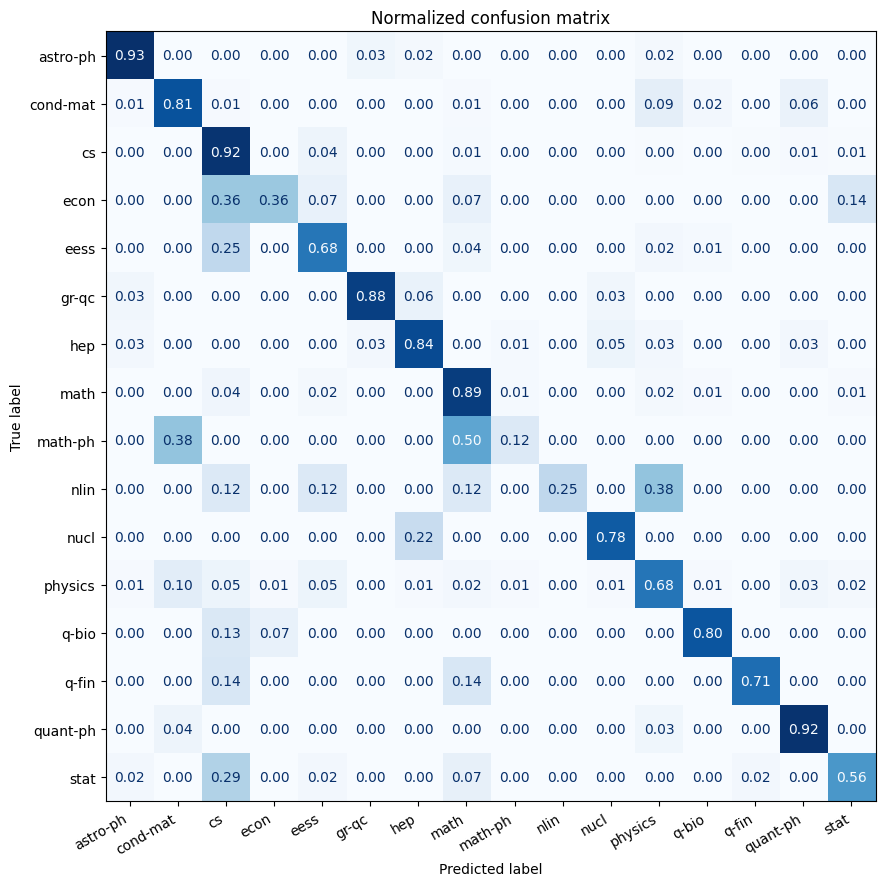

In [16]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [17]:
test_dataset = all_stream_data["test"].map(
    tokenize, batched=True, batch_size=None
)
preds_output = trainer.predict(test_dataset)
preds_output.metrics


Map:   0%|          | 0/1926 [00:00<?, ? examples/s]

{'test_loss': 0.9364782571792603,
 'test_macro_f1': 0.708450081140601,
 'test_balanced_accuracy': 0.6987666493029587,
 'test_runtime': 3.3816,
 'test_samples_per_second': 569.546,
 'test_steps_per_second': 9.167}

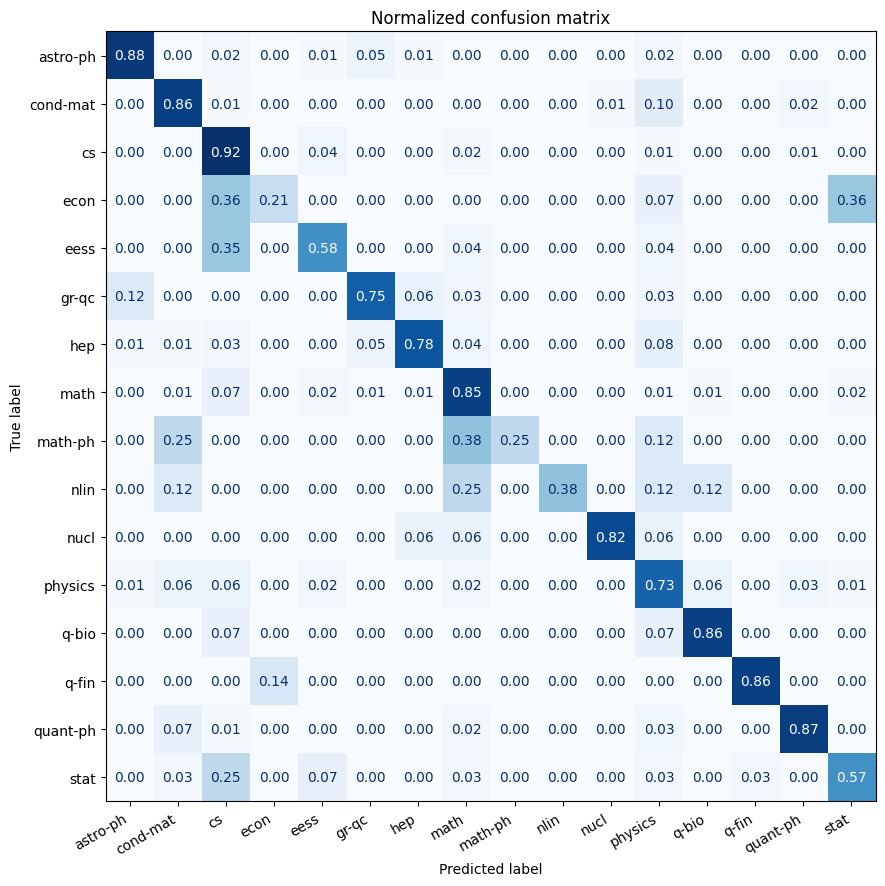

In [18]:
y_test = np.array(test_dataset["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_test, labels)


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.94      0.88      0.91       121
    cond-mat       0.85      0.86      0.86       137
          cs       0.90      0.92      0.91       819
        econ       0.60      0.21      0.32        14
        eess       0.52      0.58      0.54        85
       gr-qc       0.67      0.75      0.71        32
         hep       0.91      0.78      0.84        79
        math       0.89      0.85      0.87       331
     math-ph       1.00      0.25      0.40         8
        nlin       1.00      0.38      0.55         8
        nucl       0.93      0.82      0.88        17
     physics       0.67      0.73      0.70       124
       q-bio       0.46      0.86      0.60        14
       q-fin       0.75      0.86      0.80         7
    quant-ph       0.86      0.87      0.86        90
        stat       0.62      0.57      0.60        40

    accuracy                           0.84      1926
   macro avg       0.79   